In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev, median
from scipy.stats import median_abs_deviation

In [11]:
# create list of multiple dataframes containing participants' data
path =r'C:\Users\lttso\Desktop\foraging_ratio\data_foraging_ratio'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

In [12]:
#shows an example of unchanged df to work with
dfs[0].head()

,block_n,trial_n,training_trials,target1,target2,back_to_center,num_of_targets,condition,stim0,x_0,...,y_targ,targ_selected,valid_click,participant,age,gender,date,expName,psychopyVersion,Unnamed: 42
0,0,0,1,yellow_cc,blue_cc,False,3,feat,red_cc,87.136475,...,75.859714,True,True,1,23,m,2022_Aug_15_1133,foraging_circle,2021.2.3,NaN
1,0,0,1,yellow_cc,blue_cc,False,4,feat,yellow_cc,137.719130,...,155.264189,True,True,1,23,m,2022_Aug_15_1133,foraging_circle,2021.2.3,NaN
2,0,0,1,yellow_cc,blue_cc,False,2,feat,blue_cc,89.671777,...,82.619837,True,True,1,23,m,2022_Aug_15_1133,foraging_circle,2021.2.3,NaN
3,0,0,1,yellow_cc,blue_cc,False,3,feat,yellow_cc,135.479903,...,3.747905,True,True,1,23,m,2022_Aug_15_1133,foraging_circle,2021.2.3,NaN
4,0,0,1,yellow_cc,blue_cc,False,2,feat,red_cc,94.075401,...,79.934223,True,True,1,23,m,2022_Aug_15_1133,foraging_circle,2021.2.3,NaN


# Data frame cleaning 
##### Removing errors, extracting information like age/gender, removing unwanted columns

In [13]:
# Create a list to store cleaned dataframes
dfs_cleaned = []

# Get age and gender for further count
gender = []
age = []

#create dictionary with error rates
count = 1
error_rates_feat = dict()
error_rates_conj = dict()
error_rates = dict()

for df in dfs:
    # record age and gender for further count
    gen = df.gender.unique()
    a = df.age.unique()
    gender.append(gen[0])
    age.append(a[0])
    
    #clean df from unrelated data & columns
    df = df[df.training_trials != 1]
    df = df[df.valid_click != False]
    df = df.drop(['gender', 'age', 'date', 
                  'psychopyVersion', 'valid_click', 'expName'], axis=1) # add "Unnamed: 42" for lab data
    
    #create dfs for feature and conjunction
    df_feat = df[df['condition'] == 'feat']
    df_conj = df[df['condition'] == 'conj']
    
    
    error_selections = df.loc[(df['targ_selected'] == False), 'trial_n'].tolist()
    # calculate error rates for feture 
    actual_num_of_trials = 32 * 4
    error_select_feat = df_feat.loc[(df_feat['targ_selected'] == False), 'trial_n'].tolist()
    error_selections_feat = len(error_select_feat)
    rates_feat = 100 - (abs(error_selections_feat - actual_num_of_trials) / actual_num_of_trials * 100)
    #store error rates in dict('participant_n':error rate)
    error_rates_feat.update({str(count): rates_feat})
    
    # calculate error rates for conj 
    error_select_conj = df_conj.loc[(df_conj['targ_selected'] == False), 'trial_n'].tolist()
    error_selections_conj = len(error_select_conj)
    rates_conj = 100 - (abs(error_selections_conj - actual_num_of_trials) / actual_num_of_trials * 100)
    #store error rates in dict('participant_n':error rate)
    error_rates_conj.update({str(count): rates_conj})
    
    # calculate error rates for both conditions
    trials = 32 * 2 * 4
    error_selections_n = len(error_selections)
    rates = 100 - (abs(error_selections_n - trials) / trials * 100)
    error_rates.update({str(count): rates})
    
    count += 1
    
#     #remove error trials
#     df = df[~df['trial_n'].isin(error_selections)]
    
    #create lists of dataframes
    dfs_cleaned.append(df)

##### Additional data (age, gender)

In [14]:
age_avg = mean(age)
fem_count = gender.count('f')
male_count = gender.count('m')
print('Average age: ' + str(age_avg) + '\n' + 'Female participants number: ' + str(fem_count) + '\n' + 'Male participants number:' + str(male_count)) 

Average age: 25
Female participants number: 13
Male participants number:8


#### Error rate for both conditions

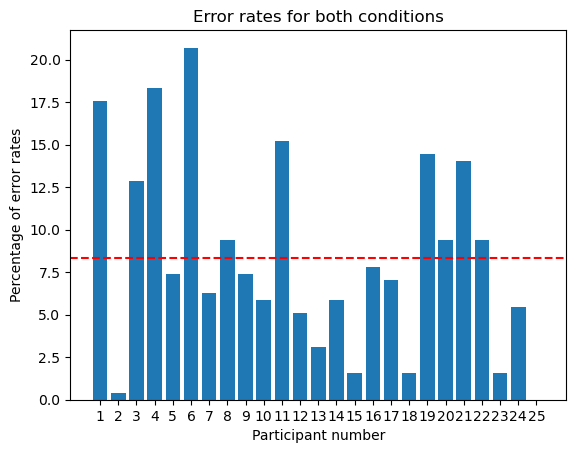

In [15]:
# Error rates plot showing precentage of error rates of each participant for both conditions
names = list(error_rates.keys())
values = list(error_rates.values())

#tick_label does the some work as plt.xticks()
error_plot = plt.bar(range(len(error_rates)),values,tick_label=names)
error_plot = plt.axhline(y=np.nanmean(values), color = 'red', linestyle ="--")
error_plot = plt.xlabel("Participant number")
error_plot = plt.ylabel("Percentage of error rates")
error_plot = plt.title("Error rates for both conditions")
plt.savefig('error_rates_both.png', dpi=1500, format='png')


#### Error rate for feature condition

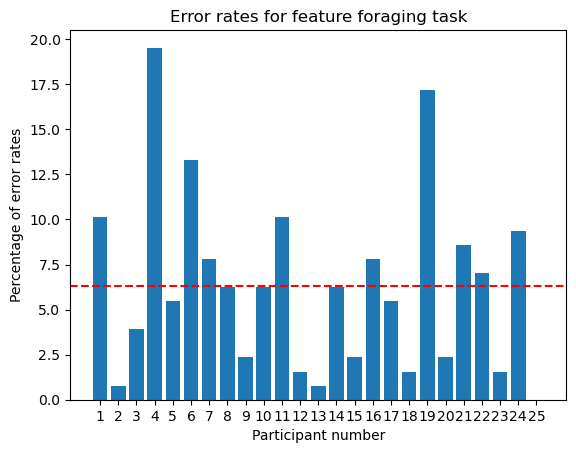

In [16]:
# Error rates plot showing precentage of error rates of each participant for feature condition
names_feat = list(error_rates_feat.keys())
values_feat = list(error_rates_feat.values())

#tick_label does the some work as plt.xticks()
error_plot_feat = plt.bar(range(len(error_rates_feat)),values_feat,tick_label=names_feat)
error_plot_feat = plt.axhline(y=np.nanmean(values_feat), color = 'red', linestyle ="--")
error_plot_feat = plt.xlabel("Participant number")
error_plot_feat = plt.ylabel("Percentage of error rates")
error_plot_feat = plt.title("Error rates for feature foraging task")
plt.savefig('error_rates_feat.png', dpi=1500, format='png')

#### Since the data is not normally distributed I used MAD to calculate exlusions

In [17]:
md_f = median(values_feat)
mad_f = median_abs_deviation(values_feat)
mad25_f = md_f + 2.5 * mad_f
part_left_f = []
part_del_f = []
for i in range(0, 25):
    if values_feat[i] < mad25_f:
        part_left_f.append(i+1)
    else:
        part_del_f.append(i+1)
print(mad25_f, part_left_f, part_del_f)

16.015625 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25] [4, 19]


#### Error rate for conjunction condition

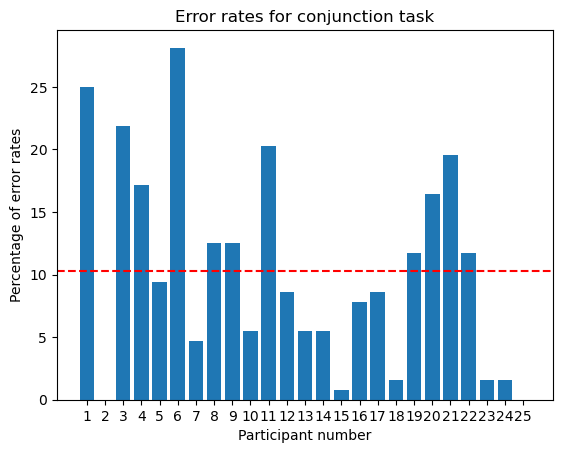

In [18]:
# Error rates plot showing precentage of error rates of each participant for conjunction condition
names_conj = list(error_rates_conj.keys())
values_conj = list(error_rates_conj.values())

#tick_label does the some work as plt.xticks()
error_plot_conj = plt.bar(range(len(error_rates_conj)),values_conj,tick_label=names_conj)
error_plot_conj = plt.axhline(y=np.nanmean(values_conj), color = 'red', linestyle ="--")
error_plot_conj = plt.xlabel("Participant number")
error_plot_conj = plt.ylabel("Percentage of error rates")
error_plot_conj = plt.title("Error rates for conjunction task")
plt.savefig('error_rates_conj.png', dpi=1500, format='png')

In [19]:
md_c = median(values_conj)
mad_c = median_abs_deviation(values_conj)
mad25_c = md_c + 2.5 * mad_c
part_left_c = []
part_del_c = []
for i in range(0, 25):
    if values_conj[i] < mad25_c:
        part_left_c.append(i+1)
    else:
        part_del_c.append(i+1)
print(mad25_f, part_left_c, part_del_c)

16.015625 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [6]


##### Baased on the +- 2.5 MAD analysis of error rates in feature condition participants 4 and 19 should be removed
##### Based on the +- 2.5 MAD analysis of error rates in conjunction condition participant 6 should be removed

In [20]:
dfs_cleaned[0].head()

,block_n,trial_n,training_trials,target1,target2,back_to_center,num_of_targets,condition,stim0,x_0,...,y_resp,click_time,direction,switch,selected_stim,x_targ,y_targ,targ_selected,participant,Unnamed: 42
151,0,0,0,red_cc,green_cc,False,2,feat,yellow_cc,88.388159,...,72.0,0.935068,1.0,1.0,green_cc,43.551334,76.141726,True,1,NaN
152,0,0,0,red_cc,green_cc,False,2,feat,red_cc,137.140876,...,-3.0,0.750802,5.0,1.0,red_cc,86.665324,-1.152307,True,1,NaN
153,0,0,0,red_cc,green_cc,False,4,feat,green_cc,179.240582,...,62.0,0.700394,2.0,0.0,red_cc,49.524313,75.924436,True,1,NaN
154,0,0,0,red_cc,green_cc,False,4,feat,red_cc,132.236104,...,-7.0,0.600555,5.0,1.0,green_cc,86.471644,-2.847731,True,1,NaN
155,0,0,0,red_cc,green_cc,False,3,feat,red_cc,175.451241,...,1.0,0.567420,3.0,1.0,red_cc,-0.011821,1.590984,True,1,NaN


## Merged dataset

In [21]:
#merge dataframes in one big df
df = pd.concat(dfs_cleaned)

In [22]:
# Remove strange column appeared only in the data from university
df = df.reset_index(drop=True)
df = df.drop('Unnamed: 42', axis=1) 

In [23]:
# Remove participants 4, 6, 19 from the data because of the high error rates
df = df.drop(df[df.participant == 4].index)
df = df.drop(df[df.participant == 6].index)
df = df.drop(df[df.participant == 19].index)

In [24]:
# check if everything is removed correctly
df.participant.unique()

array([ 1.,  2.,  3.,  5.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 20., 21., 22., 23., 24., 25.])

#### Functions to count amount of different types of targets

In [25]:
# function to calculate the number of all types of targets per selection
def targets_per_selection(row):
    num_of_targets = 0
    for i in range(0, 6):
        if row['target1'] == row['stim' + str(i)] or row['target2'] == row['stim' + str(i)]:
            num_of_targets += 1
    return num_of_targets

In [26]:
def distractors_per_selection(row):
    num_of_dist = 0
    for i in range(0, 6):
        if row['target1'] != row['stim' + str(i)] and row['target2'] != row['stim' + str(i)]:
            num_of_dist += 1
    return num_of_dist

In [27]:
# function to calculate the number of targets with the same type as a selected target
def number_of_targets_same_as_selected(row):
    num_of_same = 0
    for i in range(0, 6):
        if row['selected_stim'] == row['stim' + str(i)]:
            num_of_same += 1
    return num_of_same

In [28]:
# function to calculate the number of targets with the other type as a selected target
def number_of_targets_other_than_selected(row):
    num_of_targets = 0
    for i in range(0, 6):
        if row['target1'] == row['stim' + str(i)] or row['target2'] == row['stim' + str(i)]:
            num_of_targets += 1
    num_of_same = 0
    for i in range(0, 6):
        if row['selected_stim'] == row['stim' + str(i)]:
            num_of_same += 1
    num_of_other = num_of_targets - num_of_same
    return num_of_other

### Clean df from error selections

In [29]:
# clean data from error selections
# we decided to clean data only from error selections bt not the whole error trial
# the more data we have, the better
df_no_errors = df.drop(df[df.targ_selected == False].index)

In [30]:
df_no_errors.head()

,block_n,trial_n,training_trials,target1,target2,back_to_center,num_of_targets,condition,stim0,x_0,...,x_resp,y_resp,click_time,direction,switch,selected_stim,x_targ,y_targ,targ_selected,participant
0,0,0,0,red_cc,green_cc,False,2,feat,yellow_cc,88.388159,...,49.0,72.0,0.935068,1.0,1.0,green_cc,43.551334,76.141726,True,1.0
1,0,0,0,red_cc,green_cc,False,2,feat,red_cc,137.140876,...,93.0,-3.0,0.750802,5.0,1.0,red_cc,86.665324,-1.152307,True,1.0
2,0,0,0,red_cc,green_cc,False,4,feat,green_cc,179.240582,...,44.0,62.0,0.700394,2.0,0.0,red_cc,49.524313,75.924436,True,1.0
3,0,0,0,red_cc,green_cc,False,4,feat,red_cc,132.236104,...,80.0,-7.0,0.600555,5.0,1.0,green_cc,86.471644,-2.847731,True,1.0
4,0,0,0,red_cc,green_cc,False,3,feat,red_cc,175.451241,...,5.0,1.0,0.567420,3.0,1.0,red_cc,-0.011821,1.590984,True,1.0


### Remove RT which are out of +-2.5 MAD range

#### Calculate median, mad

In [31]:
med = df_no_errors['click_time'].median()
med

0.6014346500451211

In [32]:
mad = median_abs_deviation(df_no_errors.click_time)

In [33]:
mad_max = med + 2.5 * mad
mad_min = med - 2.5 * mad

In [34]:
df_no_min_mad = df_no_errors.drop(df_no_errors[df_no_errors.click_time < mad_min].index)
df_no_mad = df_no_min_mad.drop(df_no_min_mad[df_no_min_mad.click_time > mad_max].index)

In [35]:
# I left sd in the name of variable just to 
df_no_mad

,block_n,trial_n,training_trials,target1,target2,back_to_center,num_of_targets,condition,stim0,x_0,...,x_resp,y_resp,click_time,direction,switch,selected_stim,x_targ,y_targ,targ_selected,participant
1,0,0,0,red_cc,green_cc,False,2,feat,red_cc,137.140876,...,93.0,-3.0,0.750802,5.0,1.0,red_cc,86.665324,-1.152307,True,1.0
2,0,0,0,red_cc,green_cc,False,4,feat,green_cc,179.240582,...,44.0,62.0,0.700394,2.0,0.0,red_cc,49.524313,75.924436,True,1.0
3,0,0,0,red_cc,green_cc,False,4,feat,red_cc,132.236104,...,80.0,-7.0,0.600555,5.0,1.0,green_cc,86.471644,-2.847731,True,1.0
4,0,0,0,red_cc,green_cc,False,3,feat,red_cc,175.451241,...,5.0,1.0,0.567420,3.0,1.0,red_cc,-0.011821,1.590984,True,1.0
5,0,0,0,red_cc,green_cc,False,2,feat,blue_cc,92.308505,...,65.0,-88.0,0.650615,5.0,1.0,green_cc,41.768679,-79.341861,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44183,3,31,0,yellow_cc,blue_cc,False,4,feat,green_cc,94.230947,...,-36.0,78.0,0.433819,2.0,0.0,blue_cc,-47.963889,81.036194,True,25.0
44184,3,31,0,yellow_cc,blue_cc,False,4,feat,yellow_cc,42.799931,...,-136.0,75.0,0.450452,3.0,0.0,blue_cc,-139.439515,82.513752,True,25.0
44185,3,31,0,yellow_cc,blue_cc,False,4,feat,blue_cc,-49.060379,...,-48.0,82.0,0.417187,0.0,0.0,blue_cc,-49.060379,81.757949,True,25.0
44186,3,31,0,yellow_cc,blue_cc,False,5,feat,blue_cc,49.933948,...,7.0,0.0,0.583874,5.0,0.0,blue_cc,1.490595,0.218589,True,25.0


##### Make dict for each participant selection number 'with errors', 'without errors', 'outside 3SD range' to compare them

In [36]:
# make a dict with the number of selections with errors for each participant
keys = df['participant'].unique()
values = []
for i in keys:
    precence = df['participant'].value_counts()[i]
    values.append(precence)
n_selections_with_errors = dict(zip(keys, values))

In [37]:
# make a dict with the number of selections without error selections
key = df_no_errors['participant'].unique()
value = []
for k in keys:
    precence = df_no_errors['participant'].value_counts()[k]
    value.append(precence)
n_selections_no_errors = dict(zip(key, value))

In [38]:
# make a dict with the number of selections within the range of RT mean +- 3SD
k = df_no_mad['participant'].unique()
v = []
for i in keys:
    precence = df_no_mad['participant'].value_counts()[i]
    v.append(precence)
n_selections_sd_range = dict(zip(k, v))

In [39]:
print(n_selections_with_errors[1], n_selections_no_errors[1], n_selections_sd_range[1])

1597 1552 1240


In [40]:
difference = {key: n_selections_no_errors[key] - n_selections_sd_range.get(key, 0) for key in n_selections_no_errors}

In [41]:
perc_difference = {key: difference[key] / n_selections_no_errors.get(key, 0) for key in difference}
perc_difference.update((x, y*100) for x, y in perc_difference.items())

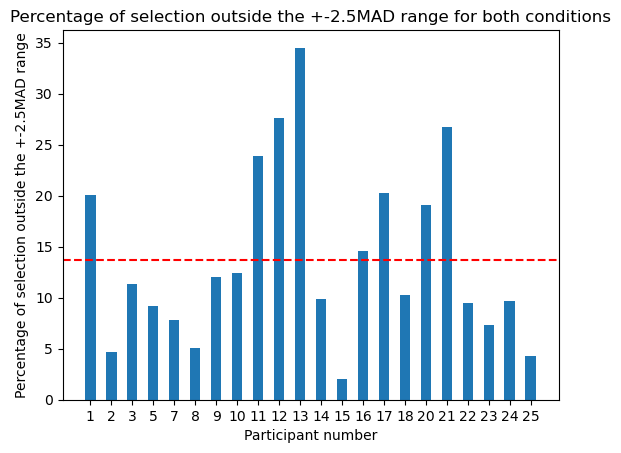

In [42]:
difference_without_mad = list(perc_difference.keys())
names = [int(i) for i in difference_without_mad]
values = list(perc_difference.values())

#tick_label does the some work as plt.xticks()
sd_plot = plt.bar(range(len(perc_difference)),values,tick_label=names, width = 0.5)
sd_plot = plt.axhline(y=np.nanmean(values), color = 'red', linestyle ="--")
sd_plot = plt.xlabel("Participant number")
sd_plot = plt.ylabel("Percentage of selection outside the +-2.5MAD range")
sd_plot = plt.title("Percentage of selection outside the +-2.5MAD range for both conditions")
# error_plot_feat.savefig('bar.png')
plt.savefig('selections_outside_mad.png', dpi=1500, format='png')

In [43]:
md_diff = median(difference_without_mad)
mad_diff = median_abs_deviation(difference_without_mad)
mad25_diff = md_diff + 2.5 * mad_diff
part_left_mad_rt = []
part_del_mad_rt = []
for i in range(0, len(difference_without_mad)):
    if values[i] < mad25_diff:
        part_left_mad_rt.append(names[i])
    else:
        part_del_mad_rt.append(names[i])
print(mad25_diff, part_left_mad_rt, part_del_mad_rt)

28.5 [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25] [13]


#### Based on the MAD exclusions participant 13 should be removed
#### In total four participants removed 4, 6, 13, 19

In [44]:
df_no_mad = df_no_mad.drop(df_no_mad[df_no_mad.participant == 13].index)

### Count how many data in total left for both conditions

In [65]:
# df[df['condition'] == 'conj'].count()
feat_select_all = sum(df['condition'] == 'feat')
conj_select_all = sum(df['condition'] == 'conj')
feat_select_with_exclusions = sum(df_no_mad['condition'] == 'feat')
conj_select_with_exclusions = sum(df_no_mad['condition'] == 'conj')
feat_select_percent_left = 100 - ((feat_select_all - feat_select_with_exclusions) * 100 / feat_select_with_exclusions)
conj_select_percent_left = 100 - ((conj_select_all - conj_select_with_exclusions) * 100 / conj_select_with_exclusions)
print('Feature condition selections percentage left: ', feat_select_percent_left, '\n',
      'Conjunction condition selections percentage left: ',conj_select_percent_left)

Feature condition selections percentage left:  82.39272388059702 
 Conjunction condition selections percentage left:  74.74491453824658


#### Add different ratio to main df without RT outside +-3SD range

In [36]:
# New columns with the number of 
# targets, distractors, targets with the same and other type as selected in selection patch  
df_no_mad['n_targets'] = df_no_mad.apply(lambda row: targets_per_selection(row), axis=1)
df_no_mad['n_distractors'] = df_no_mad.apply(lambda row: distractors_per_selection(row), axis=1)
df_no_mad['n_targets_same_as_selected'] = df_no_mad.apply(lambda row: number_of_targets_same_as_selected(row), axis=1)
df_no_mad['n_targets_other_than_selected'] = df_no_mad.apply(lambda row: number_of_targets_other_than_selected(row), axis=1)

In [37]:
# Ratio of all targets to all stimuli
df_no_mad['ratio_targets_to_all'] = df_no_mad.apply(lambda row: row.n_targets / 6, axis = 1)

In [38]:
# Ratio of one type of target to another
df_no_mad['ratio_selected_type_to_other'] = df_no_mad.apply(lambda row: row.n_targets_same_as_selected / row.n_targets_other_than_selected, axis = 1)

In [39]:
# Ratio of all distractors to all targets 
df_no_mad['ratio_distractors_to_targets'] = df_no_mad.apply(lambda row: row.n_distractors / row.n_targets, axis = 1)

In [40]:
# Ratio of distractors to target of the selected type
df_no_mad['ratio_distractors_to_targets_selected_type'] = df_no_mad.apply(lambda row: row.n_distractors / row.n_targets_same_as_selected, axis = 1)

In [41]:
# Ratio of distractors to targets different from selected type
df_no_mad['ratio_distractors_to_targets_other_than_selected'] = df_no_mad.apply(lambda row: row.n_distractors / row.n_targets_other_than_selected, axis = 1)

#### Final minor fixes (fill nan for swithes, calculate and add direction value to error responses)

In [42]:
error_index = df[df['direction'].isna()].index.tolist()

In [43]:
for r in error_index:
    for i in range(0, 6):
        if df['x_targ'][r] == df['x_'+ str(i)][r] and df['y_targ'][r] == df['y_'+ str(i)][r]:
            df['direction'][r] = i  

C:\Users\lttso\AppData\Local\Temp\ipykernel_13036\1173877738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction'][r] = i


In [44]:
df['switch'].fillna('NaN', inplace=True)

#### Create 2 output data files (with/without errors)

In [45]:
# make a csv file of data with/without errors
df.to_csv (r'C:\Users\lttso\Desktop\with_errors_foraging_ratio.csv', index = False,  mode='a', header=True)
df_no_mad.to_csv (r'C:\Users\lttso\Desktop\no_errors_sd_foraging_ratio.csv', index = False,  mode='a', header=True)

In [46]:
df_no_mad

,block_n,trial_n,training_trials,target1,target2,back_to_center,num_of_targets,condition,stim0,x_0,...,participant,n_targets,n_distractors,n_targets_same_as_selected,n_targets_other_than_selected,ratio_targets_to_all,ratio_selected_type_to_other,ratio_distractors_to_targets,ratio_distractors_to_targets_selected_type,ratio_distractors_to_targets_other_than_selected
1,0,0,0,red_cc,green_cc,False,2,feat,red_cc,137.140876,...,1.0,3,3,2,1,0.500000,2.000000,1.0,1.500000,3.000000
2,0,0,0,red_cc,green_cc,False,4,feat,green_cc,179.240582,...,1.0,5,1,4,1,0.833333,4.000000,0.2,0.250000,1.000000
3,0,0,0,red_cc,green_cc,False,4,feat,red_cc,132.236104,...,1.0,5,1,3,2,0.833333,1.500000,0.2,0.333333,0.500000
4,0,0,0,red_cc,green_cc,False,3,feat,red_cc,175.451241,...,1.0,4,2,3,1,0.666667,3.000000,0.5,0.666667,2.000000
5,0,0,0,red_cc,green_cc,False,2,feat,blue_cc,92.308505,...,1.0,3,3,2,1,0.500000,2.000000,1.0,1.500000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44183,3,31,0,yellow_cc,blue_cc,False,4,feat,green_cc,94.230947,...,25.0,4,2,1,3,0.666667,0.333333,0.5,2.000000,0.666667
44184,3,31,0,yellow_cc,blue_cc,False,4,feat,yellow_cc,42.799931,...,25.0,5,1,2,3,0.833333,0.666667,0.2,0.500000,0.333333
44185,3,31,0,yellow_cc,blue_cc,False,4,feat,blue_cc,-49.060379,...,25.0,4,2,2,2,0.666667,1.000000,0.5,1.000000,1.000000
44186,3,31,0,yellow_cc,blue_cc,False,5,feat,blue_cc,49.933948,...,25.0,6,0,2,4,1.000000,0.500000,0.0,0.000000,0.000000
